In [101]:
import pandas as pd
import numpy as np
import networkx as nx
#import geopandas
#from shapely.geometry import Point
import matplotlib.pyplot as plt
from sodapy import Socrata

In [102]:
def getData(limit):
    client = Socrata("data.cityofnewyork.us", None)
    results = client.get("2yzn-sicd", limit = limit)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [103]:
taxi = getData(1000)

In [104]:
taxi["dropoff_latitude"] = taxi["dropoff_latitude"].astype('float64')
taxi["dropoff_longitude"] = taxi["dropoff_longitude"].astype('float64')
taxi["pickup_latitude"] = taxi["pickup_latitude"].astype('float64')
taxi["pickup_longitude"] = taxi["pickup_longitude"].astype('float64')
print(len(taxi))
taxi_filtered = taxi
for i in range (len(taxi)) :
    if float(taxi_filtered.loc[i,'dropoff_latitude']) == 0 or float(taxi_filtered.loc[i,'dropoff_longitude']) == 0 or float(taxi_filtered.loc[i,'pickup_latitude']) == 0 or float(taxi_filtered.loc[i,'pickup_longitude']) == 0:
        taxi_filtered = taxi_filtered.drop(i)
coordinates = taxi_filtered[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
print(len(coordinates))

1000
975


In [105]:
lol=coordinates
pickup=lol.drop(["dropoff_longitude","dropoff_latitude"],axis=1)
dropoff=lol.drop(["pickup_longitude","pickup_latitude"],axis=1)

In [106]:
tuples=pickup.itertuples(index=False)
pickup_tuples=np.array(list(tuples))
tuples=dropoff.itertuples(index=False)
dropoff_tuples=np.array(list(tuples))

In [107]:
pickup_tuples=pickup_tuples.astype('float64')
dropoff_tuples=dropoff_tuples.astype('float64')

In [108]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

975
975
975
975


In [109]:
pickup_tuples=pickup_tuples.round(2)
dropoff_tuples=dropoff_tuples.round(2)

In [110]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

90
975
90
975


In [111]:
pickup_tuples_invert=[]
dropoff_tuples_invert=[]

for i in range(len(pickup_tuples)):
    #print(pickup_tuples[i])
    pickup_tuples_invert.append([pickup_tuples[i,1],pickup_tuples[i,0]])
pickup_tuples=np.array(pickup_tuples_invert)

for i in range(len(dropoff_tuples)):
    #print(dropoff_tuples[i])
    dropoff_tuples_invert.append([dropoff_tuples[i,1],dropoff_tuples[i,0]])
dropoff_tuples=np.array(dropoff_tuples_invert)

In [112]:
pickup_list=[]
for i in range(len(pickup_tuples)):
    a=(pickup_tuples[i,0],pickup_tuples[i,1])
    pickup_list.append(a)
dropoff_list=[]
for i in range(len(dropoff_tuples)):
    a=(dropoff_tuples[i,0],dropoff_tuples[i,1])
    dropoff_list.append(a)
#print(tuple_list)

In [113]:
edges=[]
for i in range(len(pickup_list)):
    edges.append((pickup_list[i],dropoff_list[i]))

In [114]:
edges=np.unique(np.array(edges),axis=0)

In [115]:
edge_tuples=[]
for i in range(len(edges)):
    edge_tuples.append(((edges[i,0,0],edges[i,0,1]),(edges[i,1,0],edges[i,1,1])))

In [116]:
g=nx.Graph()
#g=nx.DiGraph()

In [117]:
node_list=[]
for i in range(len(pickup_list)):
    node_list.append(pickup_list[i])
for i in range(len(dropoff_list)):
    node_list.append(dropoff_list[i])
print(len(node_list))
node_list=list(set(node_list))
print(len(node_list))
g.add_nodes_from(node_list)

1950
150


In [118]:
g.add_edges_from(edge_tuples)

In [119]:
position = {}
for i in range(len(node_list)):
    position.update({node_list[i]:node_list[i]})

In [120]:
nx.average_clustering(g)

0.2522597722593515

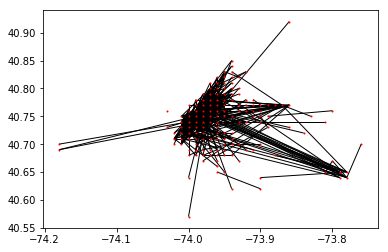

In [121]:
nx.draw_networkx(g, node_size = 1,pos=position,with_labels=False)

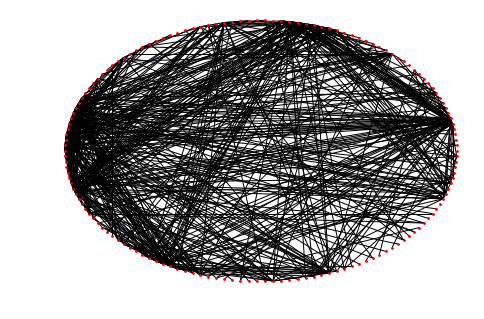

In [122]:
nx.draw_circular(g,node_size=3)

In [123]:
from networkx.algorithms import community

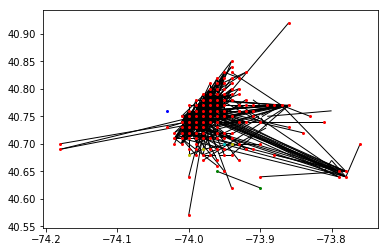

In [124]:
communities_generator = community.girvan_newman(g)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
com = sorted(map(sorted, next_level_communities))
#nx.draw_networkx_nodes(G,pos,nodelist=com[2],node_color='b',node_size=1,alpha=0.8)
#position
#nx.draw_networkx(g, node_size = 1,pos=position,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[0],node_color='r',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[1],node_color='b',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[2],node_color='y',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[3],node_color='g',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[4],node_color='w',node_size=4,with_labels=False)
nx.draw_networkx_nodes(g,position,nodelist=com[5],node_color='c',node_size=4,with_labels=False)

nx.draw_networkx_edges(g,node_size = 1,pos=position)